### Project.11  Временные ряды. Прогнозирование заказов такси

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.


### Описание данных
Данные лежат в файле taxi.csv.   

 'num_orders' признак - количество заказов   

### 1. Подготовка библиотек и данных

In [32]:
# Блок импорта
import time
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as mse, make_scorer

In [2]:
# Вспомогательные константы
RANDOM_STATE = 42

In [3]:
# отключение предупреждений
warnings.filterwarnings('ignore')

In [4]:
# Подгрузим наш файл с данными:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### Шаг 1.1. Предобработка данных

Видим,что имеем дело с временными рядами. Это надо учесть. внесем изменения в датасет.

In [5]:
try:
    df = pd.read_csv('/datasets/taxi.csv',
                     index_col=['datetime'], parse_dates=['datetime'])
except:
    df = pd.read_csv('datasets/taxi.csv',
                     index_col=['datetime'], parse_dates=['datetime'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# Проверим, что индекс монотонный
df.index.is_monotonic

True

In [7]:
# Выполним ресемплирование по одному часу
df_resampled = df.resample('1H').sum()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


####  Промежуточные выводы

Датасет у нас в целом достаточно простой и нам не потребовалось большой обработки:
- мы сделали DateTimeIndex,
- проверили монотонность, 
- сделали ресемплирование по одному часу (как того требовали условия проекта).
Можно продолжать работу с проектом.

### 2. Анализ данных

In [8]:
# Изучим границы наших данных
print("минимум:",df_resampled.index.min())
print("максимум:",df_resampled.index.max())

минимум: 2018-03-01 00:00:00
минимум: 2018-08-31 23:00:00


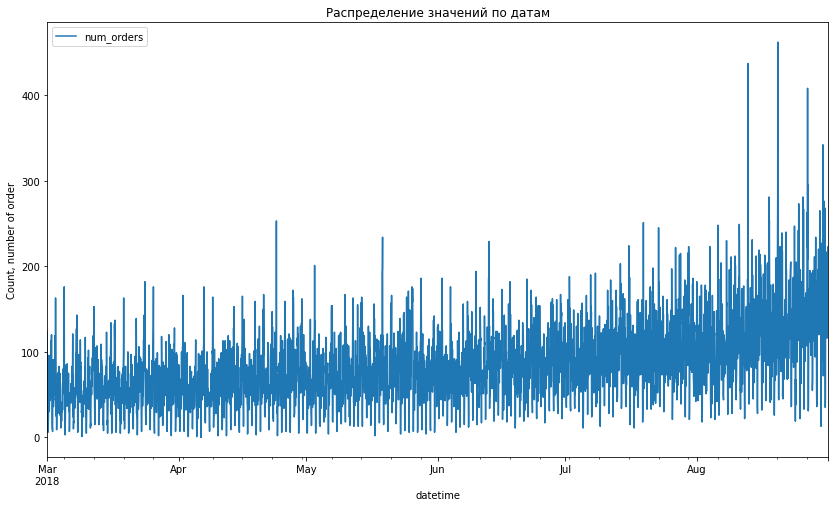

In [10]:
# Посмотрим график
def make_full_size_plot(data):
    fig, ax = plt.subplots(1)
    ax.set_title('Распределение значений по датам')
    ax.set_xlabel('Date, month')
    ax.set_ylabel('Count, number of order')
    data.plot(figsize=(14,8), ax=ax)
    
make_full_size_plot(df_resampled)

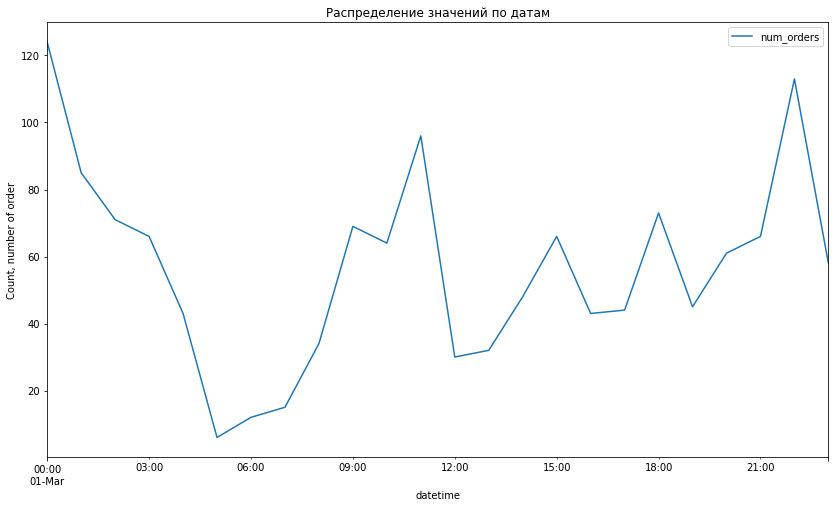

In [11]:
# Для наглядности посмотрим меньший период -  1 день.
make_full_size_plot(df_resampled.head(24))

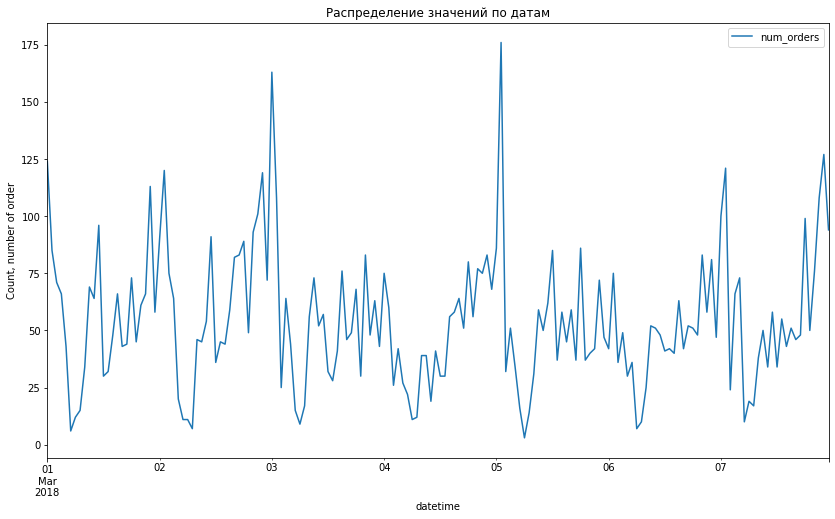

In [12]:
# Для наглядности посмотрим средний период -  7 дней.
# налицо - сезонность
make_full_size_plot(df_resampled.head(168))

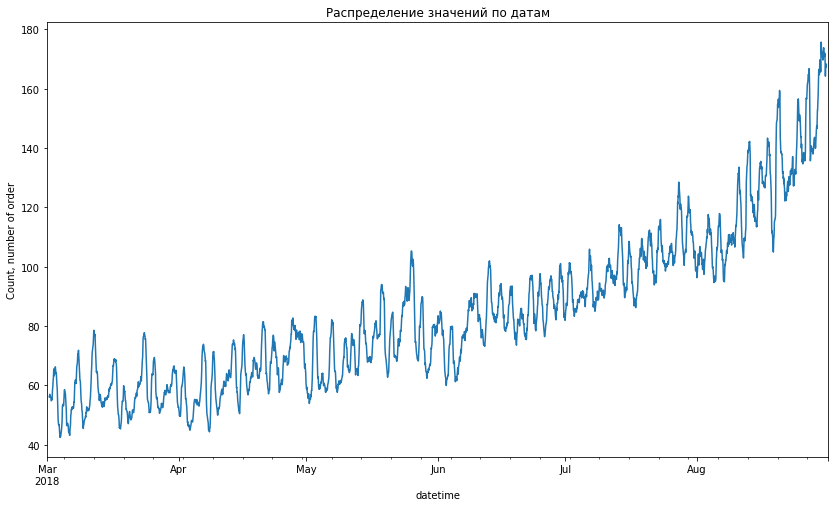

In [13]:
# Сделаем разложение временного ряда на тренд, сезонность и остаток
df_resampled_decomposed = seasonal_decompose(df_resampled)
# Тренд
make_full_size_plot(df_resampled_decomposed.trend)

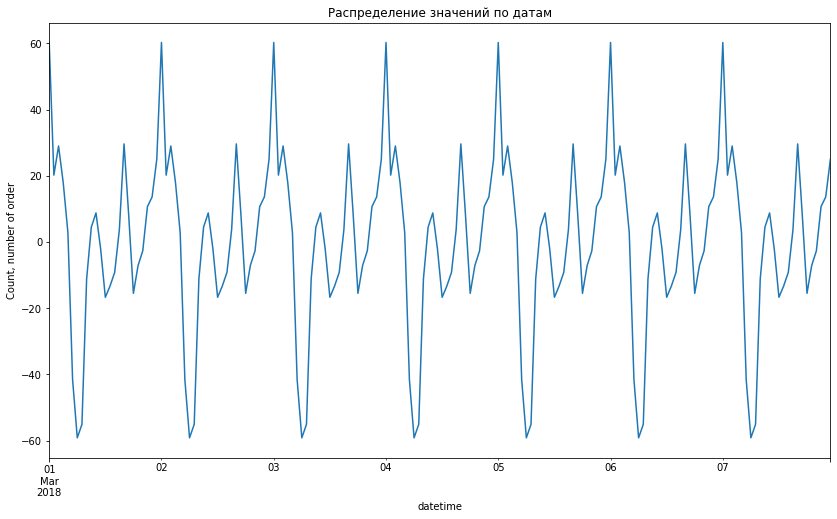

In [14]:
# Сезонность (на недельном интервале) - ярко выраженная.
make_full_size_plot(df_resampled_decomposed.seasonal.head(168))

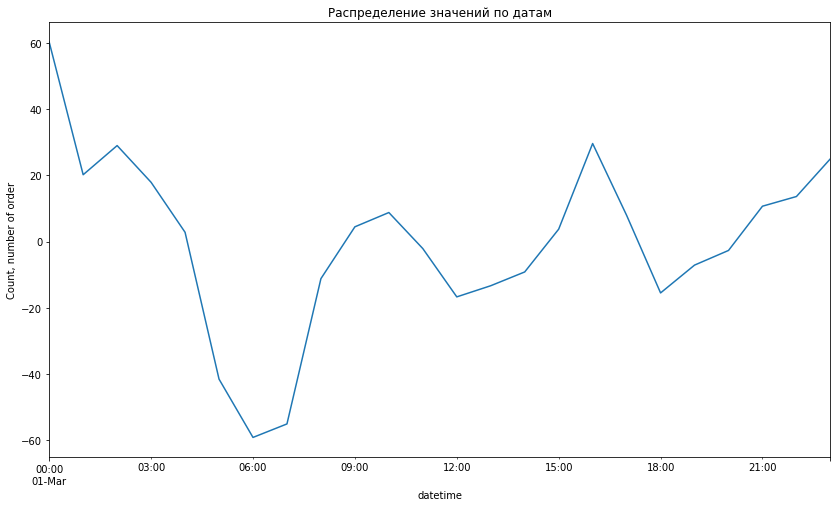

In [15]:
# Сезонность (день)
make_full_size_plot(df_resampled_decomposed.seasonal.head(24))

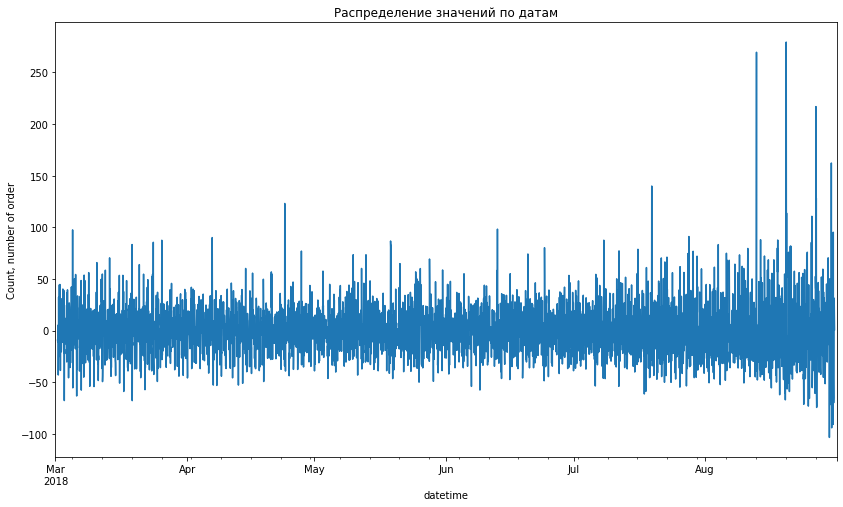

In [16]:
# Остаток
make_full_size_plot(df_resampled_decomposed.resid)

### Промежуточные выводы

 На графиках видим восходящий тренд и дневную сезонность.   
 Анализ заказов в течение дня: самым востребованным временем становятся промежуток  - полночь, также видим рост заказов в часы пик - 9 утра и 6 вечера, наверное, связано с началом/окончанием рабочего дня. 
 

### 3. Обучение моделей

In [17]:
# напишем функцию для рассчета RMSE (для оценки моделей согласно ТЗ)
def rmse(predicted, target):
    return mse(predicted, target) ** 0.5

In [18]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [19]:
# Подготовим признаки
TARGET_NAME = 'num_orders'


def make_features(df, max_lag, rolling_mean_size, use_hour):
    data = df.copy()

    # Календарные признаки
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    if use_hour:
        hour = data.index.hour
        data['hour'] = hour
        data['sin_hour'] = np.sin(2 * np.pi * hour / 24)
        data['cos_hour'] = np.cos(2 * np.pi * data.index.hour / 24)

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[TARGET_NAME].shift(lag)

    data['rolling_mean'] = data[TARGET_NAME].shift().rolling(
        rolling_mean_size).mean()

    return data

Нам предстоит сформировать признаки, затем выберем наилучший набор признаков. Испытаем
его на модели линейной регрессии. На этих признаках потом будем строить все остальные модели.
 

In [145]:
features_search_result = []

for max_lag in range(20, 61, 5):
    for rolling_mean_size in (4, 9, 2):
        for use_hour in range(2):
            features = make_features(
                df_resampled, max_lag, rolling_mean_size, bool(use_hour))
            train, test = train_test_split(
                features, shuffle=False, test_size=0.1)

            # test, validate = train_test_split(
            #    test_data, shuffle=False, test_size=0.5)

            train = train.dropna()

            train_target = train[TARGET_NAME]
            train_features = train.drop(columns=[TARGET_NAME])
            test_target = test[TARGET_NAME]
            test_features = test.drop(columns=[TARGET_NAME])

            model = LinearRegression()
            model.fit(train_features.dropna(), train_target.dropna())
            test_predicted = model.predict(test_features)

            tmp_result = dict()
            tmp_result['max_lag'] = max_lag
            tmp_result['rolling_mean_size'] = rolling_mean_size
            tmp_result['use_hour'] = use_hour
            tmp_result['rmse'] = rmse(test_predicted, test_target)

            features_search_result.append(tmp_result)

In [ ]:
features_search_result = []

for max_lag in range(20, 61, 5):
    for rolling_mean_size in (4, 9, 2):
        for use_hour in range(2):
            features = make_features(
                df_resampled, max_lag, rolling_mean_size, bool(use_hour))
            train, test = train_test_split(
                features, shuffle=False, test_size=0.1)

            # test, validate = train_test_split(
            #    test_data, shuffle=False, test_size=0.5)

            train = train.dropna()

            train_target = train[TARGET_NAME]
            train_features = train.drop(columns=[TARGET_NAME])
            test_target = test[TARGET_NAME]
            test_features = test.drop(columns=[TARGET_NAME])

            tscv = TimeSeriesSplit(n_splits=2)
            model_lr = LinearRegression()

            scores = cross_val_score(model_lr, train_features.dropna(), train_target.dropna(),
                                     scoring='neg_root_mean_squared_error',
                                     cv=tscv)

            tmp_result = dict()
            tmp_result['max_lag'] = max_lag
            tmp_result['rolling_mean_size'] = rolling_mean_size
            tmp_result['use_hour'] = use_hour
            tmp_result['rmse'] = scores.mean()

            features_search_result.append(tmp_result)

In [41]:
# Найдем наилучший набор признаков:
min_rmse_row = dict()
min_rmse_row['rmse'] = 100

for row in features_search_result:
    if (row['rmse'] < min_rmse_row['rmse']):
        min_row_rmse = row

# Посмотрим, что получилось:
min_row_rmse

{'max_lag': 60,
 'rolling_mean_size': 2,
 'use_hour': 1,
 'rmse': 41.285674882913256}

In [42]:
# Сформируем итоговые датасеты для работы:
features = make_features(
    df_resampled, min_row_rmse['max_lag'],  min_row_rmse['rolling_mean_size'], min_row_rmse['use_hour'])
train, test = train_test_split(features, shuffle=False, test_size=0.1)
train = train.dropna()

train_target = train[TARGET_NAME]
train_features = train.drop(columns=[TARGET_NAME])
test_target = test[TARGET_NAME]
test_features = test.drop(columns=[TARGET_NAME])
#validate_target = validate[TARGET_NAME]
#validate_features = validate.drop(columns=[TARGET_NAME])

In [43]:
# Проверим что у нас все логически правильно разделилось с учетом временного индекса:
print(train_features.index.min())
print(train_features.index.max())
print(test_features.index.min())
print(test_features.index.max())
# print(validate_features.index.min())
# print(validate_features.index.max())

2018-03-03 12:00:00
2018-08-13 13:00:00
2018-08-13 14:00:00
2018-08-31 23:00:00


In [44]:
# Чтобы не собирать вручную результаты, напишем класс, который будет сохранять время обучения, время предсказания и RMSE
class ModelHelper:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model

    def fit(self, features, target):
        start = time.time()
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end

    def predict(self, features, target):
        start = time.time()
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)

    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [45]:
# Создадим список, где будут храниться результаты
result = []

# И создадим функцию для вывода инфо


def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format(
        'Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(
            info[0], info[1], info[2], info[3]))

In [46]:
# Определим разбитие для всех методов:
ts_cv = TimeSeriesSplit(n_splits=2)
ts_cv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None)

### Регрессии. Линейная регрессия

In [47]:
# Попробуем линейную регрессию
model_lr = LinearRegression(normalize=True, n_jobs=-1)
model_lr_helper = ModelHelper('Linear regression', model_lr)
model_lr_helper.fit(train_features, train_target)
model_lr_helper.predict(test_features, test_target)
result.append(model_lr_helper.getResult())
print(model_lr_helper.getResult())

('Linear regression', 0.06191301345825195, 0.0016100406646728516, 41.28599454342194)


### Модель случайный лес


In [106]:
# Подберем параметры:
parameters = {'n_estimators': range(10, 101, 20), 'max_depth': range(
    5, 11, 2), 'min_samples_leaf': range(1, 7, 2), 'min_samples_split': range(2, 6, 2)}

model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
grid = GridSearchCV(model, parameters, cv=ts_cv,
                    scoring='neg_mean_squared_error')
grid.fit(train_features, train_target)

grid.best_params_

# Для отладки -
# {'max_depth': 9,
# 'min_samples_leaf': 1,
# 'min_samples_split': 4,
# 'n_estimators': 50}

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [48]:
# Проверим наш случайный лес:
model_forest = RandomForestRegressor(
    max_depth=9, min_samples_leaf=1, min_samples_split=4,
    n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)
model_forest_helper = ModelHelper('Random forest', model_forest)
model_forest_helper.fit(train_features, train_target)
model_forest_helper.predict(test_features, test_target)
result.append(model_forest_helper.getResult())
print(model_forest_helper.getResult())

('Random forest', 0.7025668621063232, 0.008042097091674805, 41.73249310124375)


### Градиентный бустинг.Модель LGBM

In [86]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE)
gbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(
    30, 101, 10), 'num_leaves': range(20, 41, 5)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=ts_cv,
                        scoring='neg_mean_squared_error')
grid_gbm.fit(train_features, train_target)

grid_gbm.best_params_

# Для отладки - {'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 20}

CPU times: user 6min 56s, sys: 46.2 s, total: 7min 43s
Wall time: 1min 4s


{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 20}

In [165]:
# Посмотрим, что получилось в итоге
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(train_features, train_target)
model_gbm_helper.predict(test_features, test_target)
result.append(model_gbm_helper.getResult())
print(model_gbm_helper.getResult())

('LightGBM', 0.13316988945007324, 0.0019817352294921875, 39.399771524716975)


### Градиентный бустинг. XGboost 

In [166]:
%%time

model_xgb = XGBRegressor(n_estimators=500, max_depth=8, 
                     n_jobs=-1, seed=RANDOM_STATE)

model_xgb_helper = ModelHelper('Xgboost', model_xgb)
model_xgb_helper.fit(train_features, train_target)
model_xgb_helper.predict(test_features, test_target)
result.append(model_xgb_helper.getResult())
print(model_xgb_helper.getResult())

('Xgboost', 3.6124508380889893, 0.00424504280090332, 45.32117687292263)
CPU times: user 23.3 s, sys: 1.83 s, total: 25.1 s
Wall time: 3.62 s


### CatBoost

In [121]:
catboost = CatBoostRegressor(loss_function='RMSE',
                        silent=True, random_seed=RANDOM_STATE)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [6, 8, 9],
        'iterations': range(0, 701, 100),
        'l2_leaf_reg': [3, 5, 7]}

grid_search_result = catboost.grid_search(grid, cv=ts_cv,
                                       X=train_features,
                                       y=train_target, 
                                       verbose=True,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 33.51007249
bestIteration = 97

0:	loss: 33.5100725	best: 33.5100725 (0)	total: 1.06s	remaining: 18.1s

bestTest = 34.10231181
bestIteration = 99

1:	loss: 34.1023118	best: 33.5100725 (0)	total: 1.93s	remaining: 15.5s

bestTest = 34.42912828
bestIteration = 98

2:	loss: 34.4291283	best: 33.5100725 (0)	total: 2.95s	remaining: 14.7s

bestTest = 32.70334434
bestIteration = 199

3:	loss: 32.7033443	best: 32.7033443 (3)	total: 4.68s	remaining: 16.4s

bestTest = 33.23865904
bestIteration = 199

4:	loss: 33.2386590	best: 32.7033443 (3)	total: 6.54s	remaining: 17s

bestTest = 33.18631431
bestIteration = 199

5:	loss: 33.1863143	best: 32.7033443 (3)	total: 8.47s	remaining: 16.9s

bestTest = 34.30857652
bestIteration = 99

6:	loss: 34.3085765	best: 32.7033443 (3)	total: 10.1s	remaining: 15.9s

bestTest = 35.25080907
bestIteration = 99

7:	loss: 35.2508091	best: 32.7033443 (3)	total: 11.7s	remaining: 14.6s

bestTest = 36.00216307
bestIteration = 99

8:	loss: 36.0021631	best: 32.703344

In [156]:
grid_search_result["params"]

{'depth': 8, 'l2_leaf_reg': 3, 'iterations': 200, 'learning_rate': 0.1}

In [167]:
# Посмотрим, что получилось в итоге
params = {'depth': 8,
          'learning_rate':  0.1,
          'iterations':  1000,
          'l2_leaf_reg': 3}
model_cat = CatBoostRegressor(**params)
model_cat_helper = ModelHelper('CatBoost', model_cat)
model_cat_helper.fit(train_features, train_target)
model_cat_helper.predict(test_features, test_target)
result.append(model_cat_helper.getResult())
print(model_cat_helper)

0:	learn: 36.6750726	total: 15.4ms	remaining: 15.3s
1:	learn: 34.9518926	total: 31.1ms	remaining: 15.5s
2:	learn: 33.4868930	total: 42.1ms	remaining: 14s
3:	learn: 32.1073826	total: 53.4ms	remaining: 13.3s
4:	learn: 30.8700684	total: 63.6ms	remaining: 12.7s
5:	learn: 29.7794661	total: 73.7ms	remaining: 12.2s
6:	learn: 28.9170833	total: 85.3ms	remaining: 12.1s
7:	learn: 28.0593038	total: 95.2ms	remaining: 11.8s
8:	learn: 27.2880355	total: 103ms	remaining: 11.4s
9:	learn: 26.5593008	total: 113ms	remaining: 11.2s
10:	learn: 25.9243983	total: 123ms	remaining: 11.1s
11:	learn: 25.4032379	total: 133ms	remaining: 10.9s
12:	learn: 24.9420141	total: 141ms	remaining: 10.7s
13:	learn: 24.4877970	total: 150ms	remaining: 10.6s
14:	learn: 24.1389768	total: 159ms	remaining: 10.4s
15:	learn: 23.7896997	total: 167ms	remaining: 10.3s
16:	learn: 23.4373010	total: 176ms	remaining: 10.2s
17:	learn: 23.1239194	total: 185ms	remaining: 10.1s
18:	learn: 22.8854075	total: 197ms	remaining: 10.1s
19:	learn: 22.63

In [160]:
print(model_cat_helper.getResult())

('CatBoost', 10.122528791427612, 0.0027289390563964844, 40.87693577964191)


### 4. Тестирование

In [168]:
# Посмотрим, что получилось:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|   Linear regression|           0.06703|           0.00168|    41.28599|
|       Random forest|           0.61074|           0.00747|    41.85426|
|            LightGBM|           0.13317|           0.00198|    39.39977|
|             Xgboost|           3.61245|           0.00425|    45.32118|
|            CatBoost|          10.30783|           0.00230|    40.87694|


Наилучший результат показала модель LightGBM.


In [169]:
# Вычислим предсказания для графика
model_gbm.fit(train_features, train_target)
test_predicted = model_gbm.predict(test_features)
rmse(test_predicted, test_target)

39.399771524716975

Результат RMSE нас удовлетворяет, т.к.  мы уложились в требования проекта (RMSE < 48).
В принципе, все модели справились с поставленной задачей.

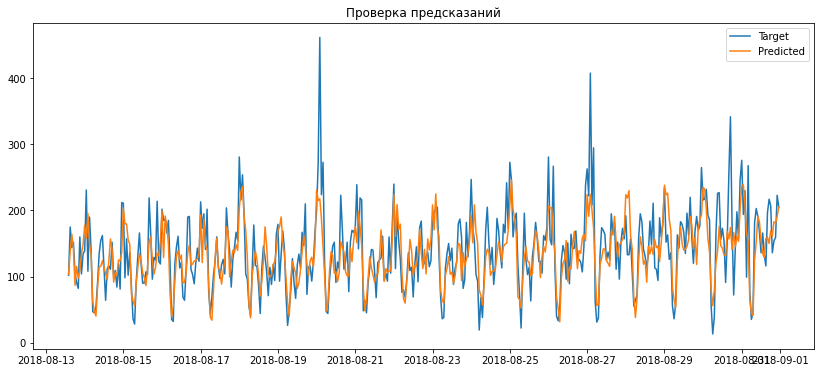

In [170]:
# Изобразим результаты предсказания на графике:
plt.figure(figsize=(14, 6))
plt.plot(test_target, label='Target')
plt.plot(test_target.index, test_predicted, label='Predicted')
plt.title('Проверка предсказаний')
plt.legend()
plt.show()

###  Итоговый вывод

 1. Мы изучили имеющиеся данные, провели необходимую подготовку, определили тренд и сезонность
 2. Создали и выбрали наилучшие признаки для обучения наших моделей
 3. С помощью этих признаков построили несколько моделей и отобрали наилучшую из них
 4. Проверили наши модели и  выполнили поставленную задачу, получив RMSE 39.399
    